### Plots used in the paper

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from tueplots import bundles
import pickle

import warnings
warnings.filterwarnings("ignore")

#### Figure 1 (heatmap): Hourly bike traffic recorded by a single counter at Unterführung Steinlach in Tübingen

In [ ]:
# Load raw bike data
bike_data = pd.read_csv("../data/full_bike_data_cleaned.csv", low_memory=False)
bike_data['timestamp'] = pd.to_datetime(bike_data['timestamp'], utc=True, errors='coerce').dt.tz_convert(
    'Europe/Berlin')

# Get data for specific counter site in specific city
city = "Stadt Tübingen"  # Select city
counter_site = 'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee'  # Select counter site
site_data = bike_data[(bike_data['city'] == city) & (bike_data['counter_site'] == counter_site)]


In [ ]:
# Helper functions to prepare data and create plot
def prepare_data(df):
    '''Extracts year, day of year, and hour from timestamp and ensures timezone is Europe/Berlin'''
    if df['timestamp'].dt.tz is None:
        df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize('UTC')
    df['timestamp'] = df['timestamp'].dt.tz_convert('Europe/Berlin')

    df['year'] = df['timestamp'].dt.year
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    df['hour'] = df['timestamp'].dt.hour

    return df


def create_yearly_strip_plot(df):
    '''Creates a strip plot of bike counts by day of year and hour for each year in the data'''
    years = sorted(df['year'].unique())
    n_years = len(years)

    # Apply style sheet for ICML 2024
    plt.rcParams.update(bundles.icml2024(column="full", nrows=7, ncols=n_years))

    # Setup Figure
    fig, axes = plt.subplots(1, n_years, sharey=True)

    # Handle single year case where axes is not a list
    if n_years == 1:
        axes = [axes]

    # Global Color Settings
    vmin, vmax = 0, df['count'].quantile(0.99)

    # Y-Axis formatting (Months)
    month_starts = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    for i, year in enumerate(years):
        ax = axes[i]

        # Prepare Data
        df_year = df[df['year'] == year]
        pivot = df_year.pivot_table(index='day_of_year', columns='hour', values='count', aggfunc='sum')
        pivot = pivot.reindex(index=range(1, 367), columns=range(0, 24), fill_value=0)
        pivot = pivot.fillna(0)

        # Plot Heatmap
        # We keep aspect='auto' because 366x24 data needs to stretch to fit the shape
        im = ax.imshow(pivot, cmap='Blues', aspect='auto',
                       vmin=vmin, vmax=vmax, origin='upper',
                       extent=[0, 24, 366, 0])

        # Labeling
        ax.set_title(str(year), pad=5, fontsize=10)

        # X-Axis
        ax.set_xticks([0, 6, 12, 18])
        ax.set_xticklabels(['00', '06', '12', '18'], rotation=90, fontsize=8)
        ax.tick_params(axis='x', length=2)

        # Y-Axis (months)
        if i == 0:
            ax.set_yticks(month_starts)
            ax.set_yticklabels(month_names, fontsize=10)
        else:
            ax.tick_params(left=False)

            # Add colorbar to the figure
    cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.6])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Bike Count', fontsize=10)
    cbar.ax.tick_params(labelsize=10)

    # Master Title
    #fig.suptitle('Bike Traffic Unterführung Steinlach, Tübingen')

    return fig

In [ ]:
# Execute plot
df_agg = prepare_data(site_data)
fig = create_yearly_strip_plot(df_agg)
#fig.savefig("../figures/bike_traffic_tuebingen.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Figure 2 (line plot + histogram): Change in bike counts depending on temperature relative to the mean temperature

In [ ]:
# Set path to load results from % TODO: which data?
file_path = "../data/temp_effect_results.pkl"

with open(file_path, "rb") as f:
        results = pickle.load(f)

In [ ]:
def plot_temp_effect_from_file(results):
    '''Plot temperature effect as line plot for observed and predicted data for different rain levels'''

    # ---- Extract results ----
    actual = results["observed"]
    predicted = results["forecast"]
    hist = results["hist"]
    temps = actual["temps"]
    mean_temp = actual["global_mean_temp"]
    curves_actual = actual["curves"]
    curves_pred = predicted["curves"]
    bins = hist["bins"]
    frac_actual = hist["frac_observed"]
    frac_pred = hist["frac_forecast"]
    rain_levels = results["meta"]["rain_levels"]
    temp_min = results["meta"]["temp_min"]
    temp_max = results["meta"]["temp_max"]

    # ---- Plot ----
    plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1))

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    # Force histograms into background
    ax2.set_zorder(0)
    ax1.set_zorder(1)
    ax1.patch.set_alpha(0)  # transparent so bars show through

    width = bins[1] - bins[0]
    ax2.patch.set_alpha(0)

    # Histogram bars
    h_actual = ax2.bar(
        bins[:-1], frac_actual,
        width=width, color="#808080", alpha=0.5,
        align="edge", zorder=0.5
    )
    h_pred = ax2.bar(
        bins[:-1], frac_pred,
        width=width, color="#E0E0E0", alpha=0.5,
        align="edge", zorder=0.5
    )

    ax2.set_ylabel("Fraction of data", fontsize=28, labelpad=10)
    ax2.set_ylim(0, max(frac_actual.max(), frac_pred.max()) * 1.1)

    actual_colors = ["#04D69E", "#009E73", "#005F40"]
    pred_colors = ["#FFB3E6", "#CC79A7", "#993366"]

    # Curves with CI
    for r, c_actual, c_pred in zip(rain_levels, actual_colors, pred_colors):
        # Actual
        ax1.fill_between(
            temps,
            curves_actual[r]["low"],
            curves_actual[r]["high"],
            color=to_rgba(c_actual, 0.20),
            zorder=2
        )
        ax1.plot(
            temps,
            curves_actual[r]["mean"],
            lw=3,
            color=c_actual,
            label=f"Rain={r} mm (obs.)",
            zorder=3
        )

        # Predicted
        ax1.fill_between(
            temps,
            curves_pred[r]["low"],
            curves_pred[r]["high"],
            color=to_rgba(c_pred, 0.20),
            zorder=2.5
        )
        ax1.plot(
            temps,
            curves_pred[r]["mean"],
            lw=3,
            color=c_pred,
            label=f"Rain={r} mm (pred.)",
            zorder=4
        )

    # Global mean temp line
    ax1.axvline(
        mean_temp,
        color="black",
        lw=2,
        ls="--",
        label=rf"Global mean temp $\approx$ {mean_temp:.1f}$^\circ$C",
        zorder=4
    )
    # Add text next to the line
    ax1.text(
        mean_temp + 0.5,  # slightly to the right of the line
        ax1.get_ylim()[1] * (-0.7),  # near top of y-axis
        rf"mean temp. $\approx$ {mean_temp:.1f}$^\circ$C",
        color="black",
        fontsize=22,
        ha="left",  # horizontal alignment
        va="top",  # vertical alignment
        rotation=0
    )
    # Labels, ticks, and axis limits
    ax1.set_xlabel("Temperature (°C)", fontsize=28)
    ax1.set_ylabel(r"Change in bike counts (\%)", fontsize=28, labelpad=10)
    #ax1.set_yticks([-75, -50, -25, 0, 25, 50, 75])

    ax1.tick_params(axis='both', which='major', labelsize=24)
    ax2.tick_params(axis='y', which='major', labelsize=24)

    # Add margins at ends
    ax1.margins(x=0.02, y=0.05)

    # X-axis limits
    ax1.set_xlim(temp_min, temp_max)

    # Combine legends (removed for clarity)
    #handles1, labels1 = ax1.get_legend_handles_labels()
    #handles2 = [h_actual, h_pred]
    #labels2 = ["Observed temperature", "Predicted temperature"]
    #ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left", fontsize=14)

    return fig

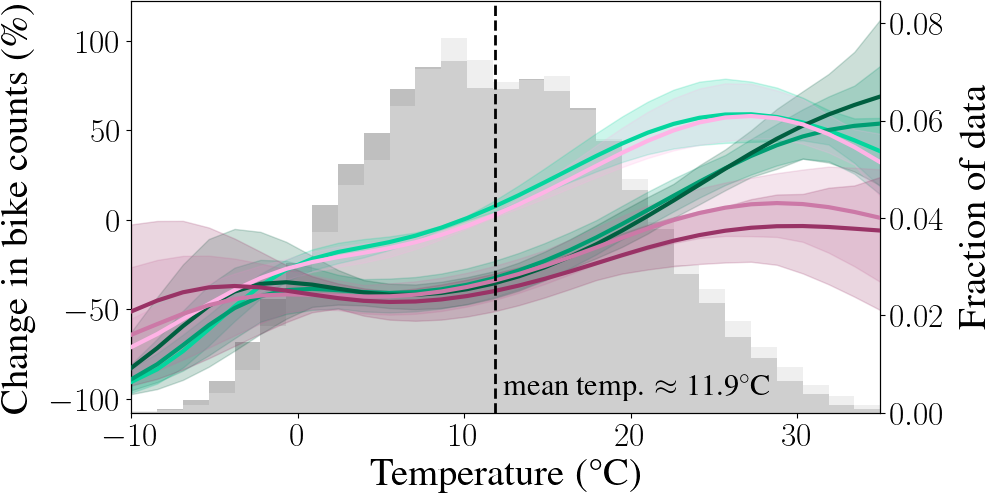

In [ ]:
# Execute plot 
plot_temp_effect_from_file(results)
#fig.savefig("../figures/pred_vs_obs_wheather.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Figure 3 (forest plot): Pairwise comparison of model predictive performance

In [3]:
# Load data 
mean_differences_df = pd.read_csv('../data/mean_mae_differences_forest_plot.csv', low_memory=False)
bootstrap_df = pd.read_csv('../data/mae_differences_per_city.csv', low_memory=False)

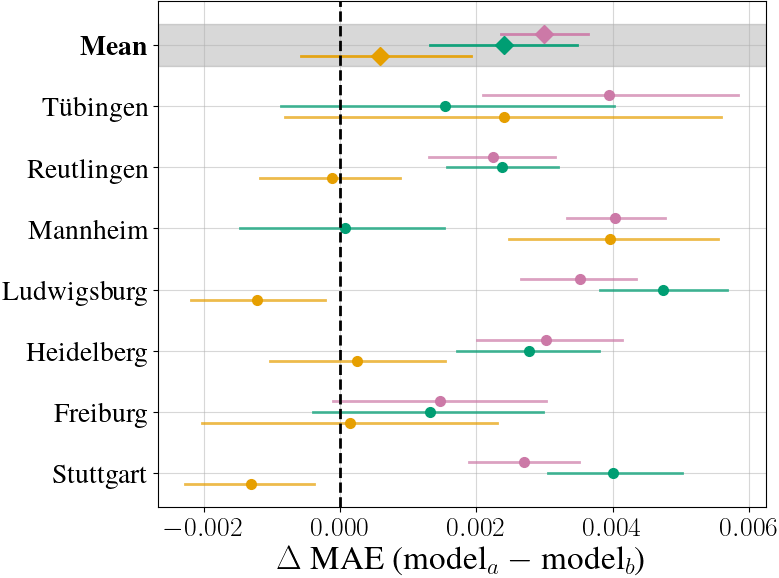

In [ ]:
# Plot function
def forest_plot_mae_differences(bootstrap_df, mean_differences_df):
    '''Creates a forest plot of MAE differences with confidence intervals for different model comparisons'''
    # Figure setup
    plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1))
    fig, ax = plt.subplots(figsize=(8, 6))

    # Colors
    colors = {'forecast - observed': '#E69F00', 
            'observed - combined': '#009E73', 
            'forecast - combined': '#CC79A7'}

    comparisons = ['forecast - observed', 'observed - combined', 'forecast - combined']
    cities = bootstrap_df['city'].unique()

    y_position = 0
    y_ticks = []
    y_labels = []
    offset = 0.07  # Abstand zwischen den Vergleichen pro Stadt

    for city in cities:
        y_labels.append(city.split()[-1])
        city_middle = y_position + offset
        y_ticks.append(city_middle)
        
        for i, comparison in enumerate(comparisons):
            row = bootstrap_df[(bootstrap_df['city'] == city) & 
                            (bootstrap_df['model_comparison'] == comparison)].iloc[0]
            
            y_pos = y_position + i * offset
            
            # Confidence interval
            ax.plot([row['CI_lower'], row['CI_upper']], [y_pos, y_pos], 
                    color=colors[comparison], linewidth=2, alpha=0.7)
            # Point for MAE difference
            ax.plot(row['MAE_difference'], y_pos, 'o', 
                    color=colors[comparison], markersize=7)
        
        y_position += 0.4  # Distance between cities
        
    # Mean over all cities
    y_position += 0
    y_ticks.append(y_position + offset)
    y_labels.append(r'\textbf{Mean}')

    ax.axhspan(
        y_position + offset + 2*offset,
        y_position + offset - 2*offset,
        color='gray',
        alpha=0.3,
        zorder=0
    )

    for i, comparison in enumerate(comparisons):
        mean_data = mean_differences_df[mean_differences_df['model_comparison'] == comparison].iloc[0]
        
        y_pos = y_position + i * offset
        
        ax.plot([mean_data['CI_lower'], mean_data['CI_upper']], [y_pos, y_pos], 
                color=colors[comparison], linewidth=2, alpha=0.9)
        ax.plot(mean_data['mean_MAE_difference'], y_pos, 'D', 
                color=colors[comparison], markersize=9, label=comparison)

    # Add zero line
    ax.axvline(0, color='black', linestyle='--', linewidth=2)

    # Format axes
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=20)
    ax.set_xlabel(r'$\Delta$ MAE (model$_a$ $-$ model$_b$)', fontsize=24)
    ax.tick_params(axis='x', labelsize=20)
    ax.grid(alpha=0.5)

    plt.tight_layout()
    return fig

In [ ]:
# Execute plot 
fig = forest_plot_mae_differences(bootstrap_df, mean_differences_df)
# Save figure
#fig.savefig("../figures/forest_plot_mae_differences.pdf", format="pdf", bbox_inches="tight")
plt.show()